In [1]:
#import imaging_behavior_functions
import imaging_behavior_functions_cleaned
import imaging_behavior_functions_plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from scipy.stats import circmean, circstd, circvar



### Load old

In [34]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/"
folder_name = "20230728-4_MBON09_GCAMP7f_odor_patchy_strip_fly2"
example_path_data = base_path+folder_name+"/data/"
example_path_results = base_path+folder_name+"/results/"
trial_num = 1

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions_cleaned.load_intermediate_mat(example_path_data, trial_num)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
behav_df = imaging_behavior_functions_cleaned.reconstruct_path(behav_df, ball_d=9)
# calculate straightness
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
if 'odor_state' in behav_df.columns and np.mean(behav_df.odor_state) != 0:
    behav_df = imaging_behavior_functions_cleaned.compute_event_metrics_3(behav_df)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
neural_df = imaging_behavior_functions_cleaned.add_dan_mean_columns(neural_df)
#neural_df = add_min_max_normalized_columns(neural_df)
roi_kw = 'hDeltaB'
roi_kw2 = 'MB'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df,param_df = imaging_behavior_functions_cleaned.fit_sinusoid(neural_df, roi_mtx)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T,neural_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(behav_df, neural_df)

Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.


In [18]:
shifted_heading = (merged_df['heading'] + np.pi) % (2 * np.pi)
merged_df['shifted_heading'] = shifted_heading

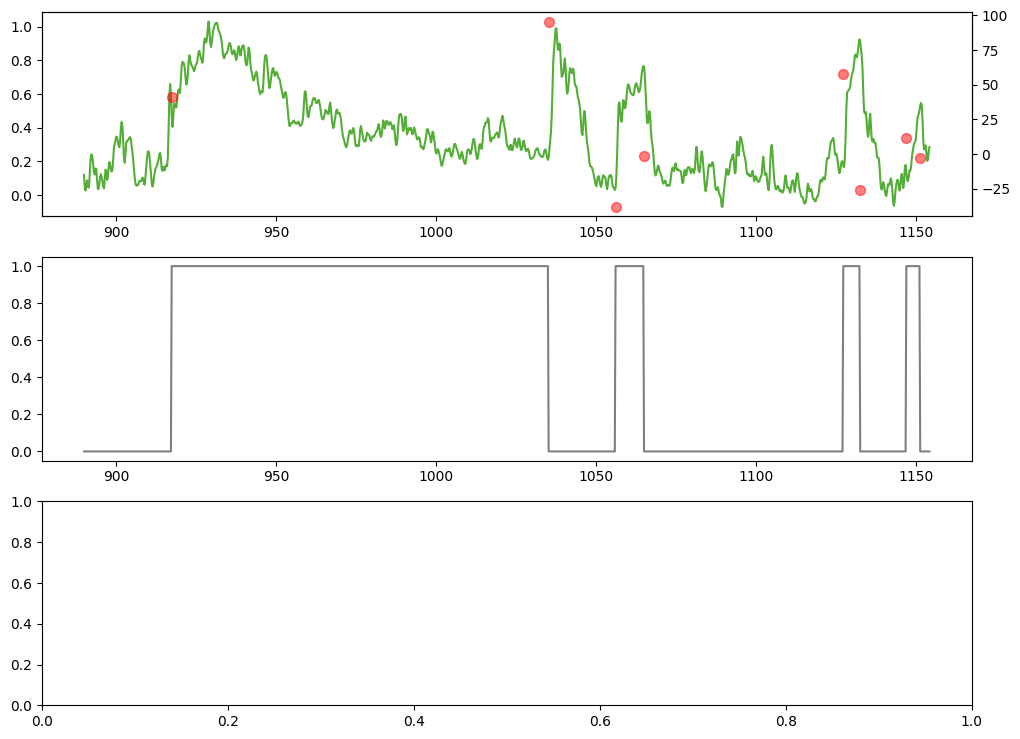

In [60]:
key = 'mean_MBON09'
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
idx1 = 3700
idx2 = 4800
ax[0].plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color=(41/256,154/256,4/256),alpha=0.8)
ax1=ax[0].twinx()
ax1.scatter(merged_df.time[idx1:idx2], merged_df['novelty_score'][idx1:idx2],color='red',s=50,alpha=0.5)
#ax[1].plot(merged_df.time[idx1:idx2], merged_df.shifted_heading[idx1:idx2],color=(110/256,80/256,160/256),alpha=0.8)
# ax2=ax[1].twinx()
#ax2.scatter(merged_df.time[idx1:idx2], merged_df['novelty_score'][idx1:idx2],color='red',alpha=0.5)
ax[1].plot(merged_df.time[idx1:idx2], merged_df['odor_state'][idx1:idx2],color='black',alpha=0.5)

plt.savefig('saved_images/mbon09_odor.pdf', facecolor='none', bbox_inches='tight', dpi=300)

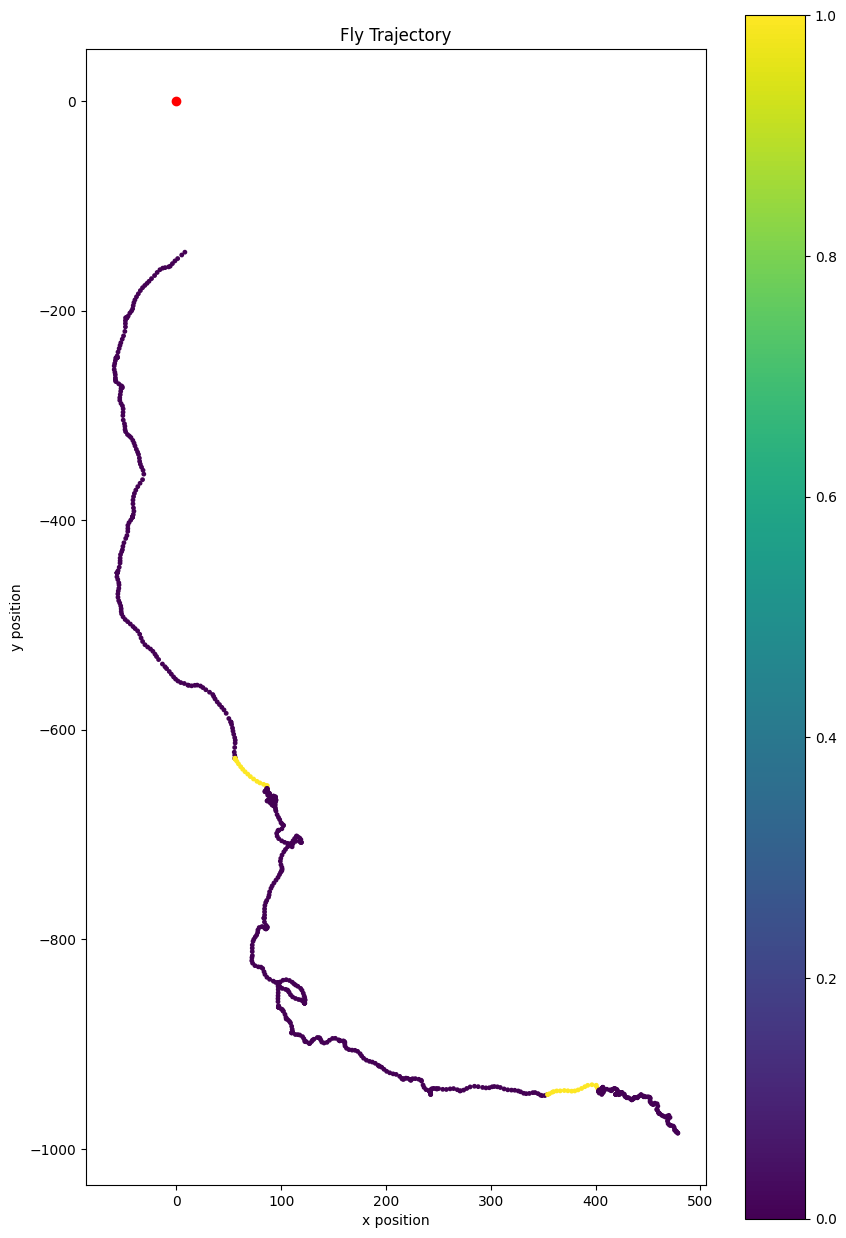

In [31]:
idx1=700
idx2=1500
imaging_behavior_functions_plotting.plot_fly_traj(merged_df.xPos[idx1:idx2], merged_df.yPos[idx1:idx2], merged_df[idx1:idx2], 'odor_state',colormap=cm.viridis)

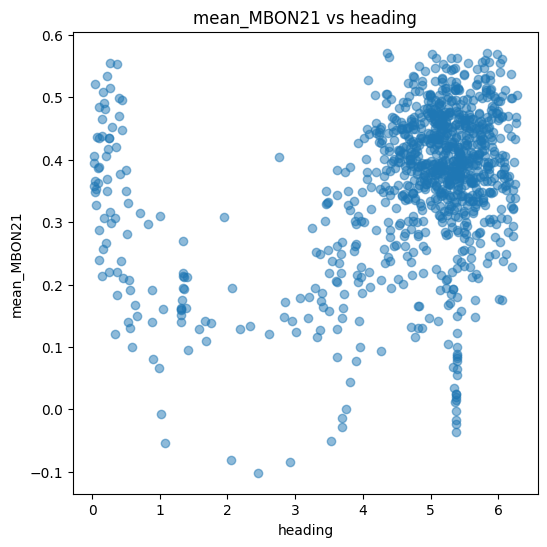

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
imaging_behavior_functions_plotting.plot_scatter(merged_df[idx1:idx2], 'heading', key, ax=ax, return_fig=False)

d:\Wilson lab\analysis\thesis-2p-behavior-align\imaging\imaging_behavior_functions_plotting.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fwV_bin'] = pd.cut(df[fwV_col], bins=fwV_bins, labels=False, include_lowest=True)
d:\Wilson lab\analysis\thesis-2p-behavior-align\imaging\imaging_behavior_functions_plotting.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heading_bin'] = pd.cut(df[heading_col], bins=heading_bins, labels=False, include_lowest=True)


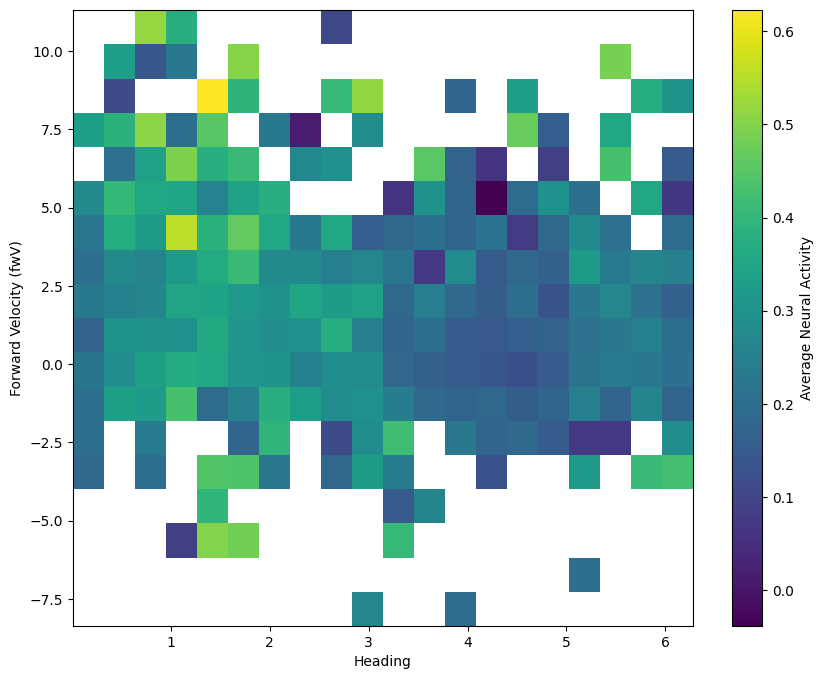

In [76]:
imaging_behavior_functions_plotting.plot_neural_activity_heatmap(merged_df.iloc[idx1:idx2], key, 'fwV', 'phase', modal_heading=None, num_bins_fwV=20, num_bins_heading=20)

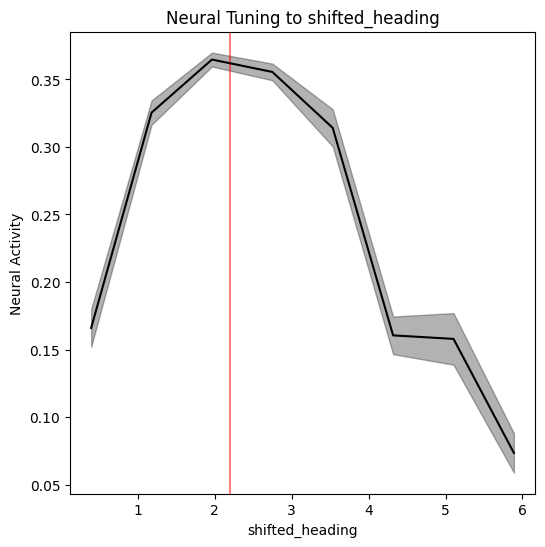

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
idx1 = 0
idx2 = -1
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['shifted_heading'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)
imaging_behavior_functions_plotting.tuning_curve_1d(merged_df[idx1:idx2], 'shifted_heading', key, num_bins=8, ax=ax, return_fig=False)



Original circular mode: 2.199114857512855
Shift amount: 0.9424777960769379
New circular mode: 3.036872898470133


Text(0.5, 1.0, 'Tuning curve with mode centered at π')

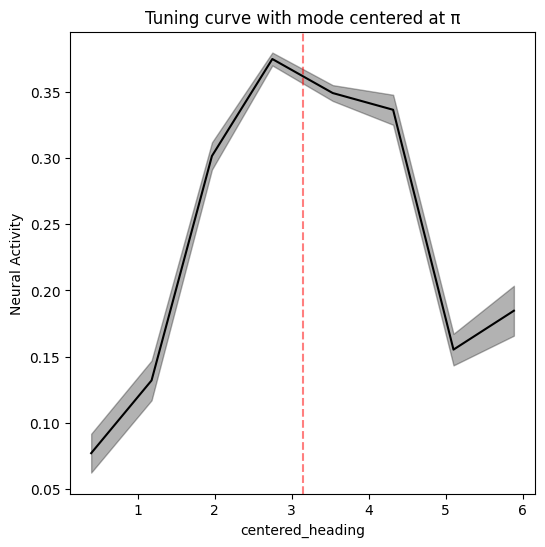

In [33]:
# Shift the heading data to make circular mode at np.pi
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['shifted_heading'], method='histogram')
print(f"Original circular mode: {circular_mode}")

# Calculate the shift needed to center the mode at np.pi
shift_amount = np.pi - circular_mode
print(f"Shift amount: {shift_amount}")

# Apply the shift and ensure values stay within [0, 2π]
centered_heading = (merged_df['shifted_heading'] + shift_amount) % (2 * np.pi)
merged_df['centered_heading'] = centered_heading

# Verify the new mode is at np.pi
new_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['centered_heading'], method='histogram')
print(f"New circular mode: {new_mode}")

# Create the plot with the centered heading
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(np.pi, color='red', linestyle='--', alpha=0.5, label='Circular Mode')
imaging_behavior_functions_plotting.tuning_curve_1d(
    merged_df[idx1:idx2], 
    'centered_heading', 
    key, 
    num_bins=8, 
    ax=ax, 
    return_fig=False
)
ax.set_title(f'Tuning curve with mode centered at π')
#ax.legend()

<PolarAxes: >

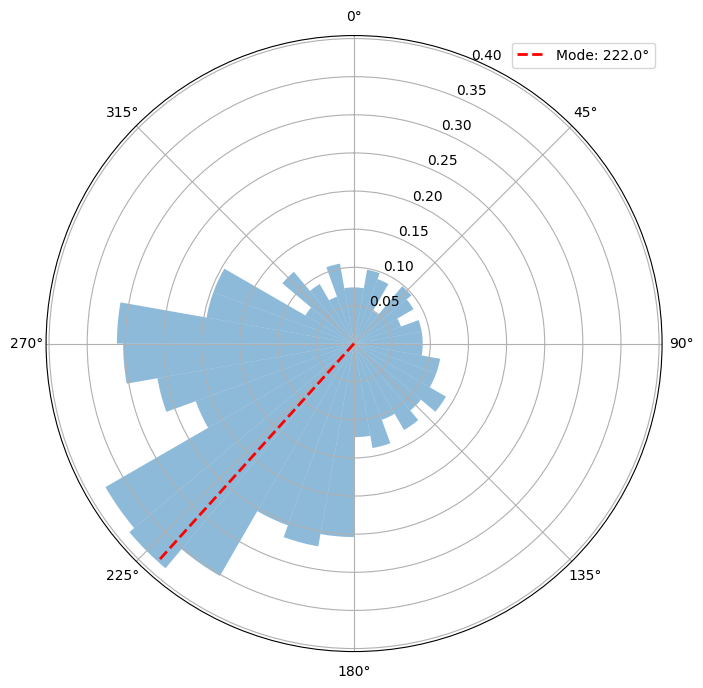

In [124]:
imaging_behavior_functions_plotting.plot_heading_histogram_circular(shifted_heading[idx1:idx2], n_bins=36, ax=None, density=True, offset=0, direction='clockwise', zero_location='N')

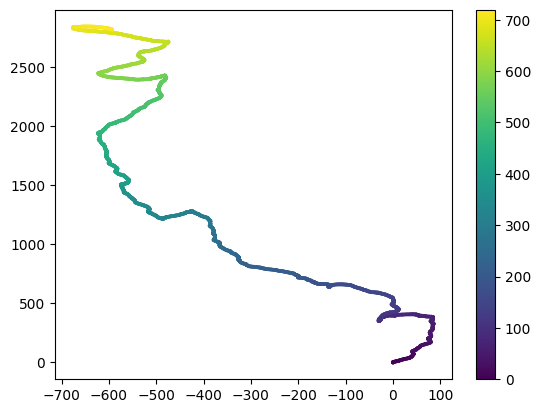

In [80]:
fig = plt.scatter(behav_df.xPos[idx1:idx2],behav_df.yPos[idx1:idx2],s=3,c = behav_df.time[idx1:idx2])
plt.colorbar(fig)

### Load new and examine bar sweep

#### Useful functions

In [4]:
def compute_prestimulus_metrics(df, state_col="odor_state", time_col="time",
                                fwv_col="fwV", heading_col="heading", rho_t_col="rho_t",
                                pre_window=5):
    """
    Computes prestimulus locomotion metrics at off-to-on transitions.
    
    For each off-to-on transition (i.e., when the state changes from 0 to 1), the following metrics are computed:
      - Prestimulus average forward velocity (fwV) over the time window preceding the transition.
      - Prestimulus circular average of heading.
      - Prestimulus circular variance of heading (assuming heading is in the range [0, π]).
      - Prestimulus average rho_t (straightness measure).
      - Average fwV during the entire on period (from transition onset to next off transition).
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing locomotion data.
    - state_col (str): Name of the binary state column (0 = off, 1 = on).
    - time_col (str): Name of the time column.
    - fwv_col (str): Column name for forward velocity.
    - heading_col (str): Column name for heading (in radians, assumed to be in [0, π]).
    - rho_t_col (str): Column name for straightness measure.
    - pre_window (float): Duration (in the same units as time_col) of the prestimulus window.
    
    Returns:
    - pd.DataFrame with the following additional columns:
        - 'prestim_avg_fwv': Prestimulus average forward velocity.
        - 'prestim_circavg_heading': Prestimulus circular average of heading.
        - 'prestim_circvar_heading': Prestimulus circular variance of heading.
        - 'prestim_avg_rho_t': Prestimulus average straightness.
        - 'on_avg_fwv': Average forward velocity during the on period.
    """


    # Identify off-to-on transitions: where the previous state is 0 and the current state is 1.
    onset_indices = df.index[(df[state_col].shift(1, fill_value=0) == 0) & (df[state_col] == 1)]
    # Identify on-to-off transitions for computing on period metrics.
    offset_indices = df.index[(df[state_col].shift(1, fill_value=1) == 1) & (df[state_col] == 0)]

    # Initialize new metric columns with NaN.
    df["prestim_avg_fwv"] = np.nan
    df["prestim_circavg_heading"] = np.nan
    df["prestim_circvar_heading"] = np.nan
    df["prestim_avg_rho_t"] = np.nan
    df["on_avg_fwv"] = np.nan

    for event_idx in onset_indices:
        event_time = df.loc[event_idx, time_col]

        # Define prestimulus window: from (event_time - pre_window) to event_time.
        window_start_time = event_time - pre_window
        prestim_window = df[(df[time_col] >= window_start_time) & (df[time_col] < event_time)]

        if not prestim_window.empty:
            # Calculate prestimulus metrics.
            df.loc[event_idx, "prestim_avg_fwv"] = prestim_window[fwv_col].mean()
            df.loc[event_idx, "prestim_avg_rho_t"] = prestim_window[rho_t_col].mean()
            # Compute circular statistics for heading.
            df.loc[event_idx, "prestim_circavg_heading"] = circmean(prestim_window[heading_col])
            df.loc[event_idx, "prestim_circvar_heading"] = circvar(prestim_window[heading_col])

        # Define the on period: from the event time to the next off event.
        next_offsets = offset_indices[offset_indices > event_idx]
        if not next_offsets.empty:
            next_off_idx = next_offsets.min()
            on_window = df[(df[time_col] >= event_time) & (df[time_col] < df.loc[next_off_idx, time_col])]
        else:
            # If no subsequent off event exists, take all data from event_time to end.
            on_window = df[df[time_col] >= event_time]

        if not on_window.empty:
            df.loc[event_idx, "on_avg_fwv"] = on_window[fwv_col].mean()

    return df


def plot_neural_activity(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"], sigma=None, plot_kw='past_interval', is_onset=True, bounds=[10, 25, 100, 200],percentile_range=[0, 100]):
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_filter1d(df[column], sigma)

    heading_onsets = df.index[(df["heading_state"].shift(1, fill_value=0) == 0) & (df["heading_state"] == 1)]
    heading_offsets = df.index[(df["heading_state"].shift(1, fill_value=0) == 1) & (df["heading_state"] == 0)]

    fig, axs = plt.subplots(len(plot_columns) // 2, 2, figsize=(12, 2 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(heading_onsets) - 1):
            onset = heading_onsets[j]
            offset = heading_offsets[j]
            
            if is_onset:
                start = max(0, onset - pre_window_size)
                end = min(len(df), onset + post_window_size)
                time_ref = onset
            else:
                start = max(0, offset - pre_window_size)
                end = min(len(df), offset + post_window_size)
                time_ref = offset
            
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[time_ref]

            if np.array(time_trace)[-1] > 0 and np.array(time_trace)[0] < 0:
                aligned_traces.append((time_trace.reset_index(drop=True), trace))
                if is_onset:
                    value = df.loc[onset, plot_kw]
                else:
                    value = df.loc[offset, plot_kw]
                if value is not None:
                    trace_colors.append(value)
        
        if trace_colors:
            lower_bound, upper_bound = np.percentile(trace_colors, percentile_range)
            norm = plt.Normalize(max(min(trace_colors), lower_bound), min(max(trace_colors), upper_bound))
            cmap = plt.cm.rainbow
        
        for idx, (time_trace, trace) in enumerate(aligned_traces):
            color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            axs[i].plot(time_trace, trace, alpha=0.4, color=color)

        if bounds:
            grouped_traces = {str(idx): [] for idx in range(len(bounds) + 1)}
            
            for idx, value in enumerate(trace_colors):
                if value < bounds[0]:
                    grouped_traces["0"].append(aligned_traces[idx][1])
                else:
                    for b_idx in range(1, len(bounds)):
                        if bounds[b_idx - 1] <= value < bounds[b_idx]:
                            grouped_traces[str(b_idx)].append(aligned_traces[idx][1])
                            break
                    else:
                        grouped_traces[str(len(bounds))].append(aligned_traces[idx][1])
            
            for group, traces in grouped_traces.items():
                if traces:
                    mean_trace = pd.DataFrame(traces).mean()
                    mean_time = pd.Series([-pre_window_size + i for i in range(pre_window_size + post_window_size)])
                    
                    group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors)
                                    if (value < bounds[0] and group == "0") or
                                    any(bounds[b_idx - 1] <= value < bounds[b_idx] and group == str(b_idx) for b_idx in range(1, len(bounds))) or
                                    (value >= bounds[-1] and group == str(len(bounds)))]
                    
                    if group_values:
                        group_avg = np.mean(group_values)
                        color = cmap(norm(group_avg))
                        axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
     
        
        axs[i].axvline(x=0, color='red', linestyle='--', label='Heading Onset')
        
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel(f"Time (seconds, aligned to heading {'onset' if is_onset else 'offset'})")
        axs[i].set_ylabel("Activity")
    
    plt.tight_layout()
    plt.show()


def plot_aligned_traces_twinx(
    df, 
    binary_col, 
    query_cols,  # expects exactly two columns: e.g. ['MBON09', 'heading']
    time_col, 
    align_to="on", 
    window=(-1, 1), 
    is_circular=False,  # can be a boolean or list/tuple of booleans [for left, for right]
    do_baselincorr=True
):
    """
    Plots two query variable traces aligned to binary state transitions.
    The first variable (query_cols[0]) is plotted on the left y-axis,
    while the second variable (query_cols[1]) is plotted on a twin y-axis.
    For each variable, if it is circular (e.g. angles in radians) it is plotted as a scatter plot.
    
    Parameters:
      - df: DataFrame containing the time series.
      - binary_col: Column name used to detect transitions (e.g., landmark jumps).
      - query_cols: List of exactly two column names (e.g., ['MBON09', 'heading']).
      - time_col: Column name with time values.
      - align_to: Either "on" or "off" indicating which transitions to align.
      - window: Tuple (start, end) relative to the transition time.
      - is_circular: Boolean or list/tuple of booleans. If True for a variable, baseline correction 
                     uses circular statistics and the variable is plotted as scatter.
      - do_baselincorr: If True, subtracts the pre-event (t < 0) baseline from each trace.
    """

    # Allow is_circular to be specified per variable
    if not isinstance(is_circular, (list, tuple)):
        is_circular = [is_circular, is_circular]
    elif len(is_circular) != 2:
        raise ValueError("is_circular must be either a single boolean or a list/tuple of two booleans.")

    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")
    
    num_events = len(transition_idxs)
    if num_events == 0:
        print("No transitions detected.")
        return
    
    # Create a grid of subplots: one per jump event
    ncols = int(np.ceil(np.sqrt(num_events)))
    nrows = int(np.ceil(num_events / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)

    # Set default colors for the two variables
    color_left = 'b'
    color_right = 'r'
    
    # Iterate over each event
    for i, idx in enumerate(transition_idxs):
        ax = axs[i // ncols, i % ncols]
        t0 = df.loc[idx, time_col]
        start_time = t0 + window[0]
        end_time = t0 + window[1]
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
        if subset.empty:
            continue
        
        # Align time to the event (t=0)
        aligned_time = subset[time_col].values - t0

        # Calculate average forward velocity (fwV) in the prestimulus window (t < 0)
        if 'fwV' in subset.columns:
            prestim_mask = aligned_time < 0
            if prestim_mask.any():
                avg_fwV = np.mean(np.abs(subset.loc[prestim_mask, 'fwV'].values))
            else:
                avg_fwV = np.nan
        else:
            avg_fwV = np.nan


        # Process first variable (left y-axis)
        trace_left = subset[query_cols[0]].values.copy()
        if do_baselincorr:
            baseline_mask = aligned_time < 0
            baseline_vals = trace_left[baseline_mask] if baseline_mask.any() else trace_left
            if is_circular[0]:
                baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                if baseline < 0:
                    baseline += 2 * np.pi
                trace_left = (trace_left - baseline) % (2 * np.pi)
            else:
                baseline = np.mean(baseline_vals)
                trace_left = trace_left - baseline

        # Plot left variable using scatter if circular, otherwise a line
        if is_circular[0]:
            ax.scatter(aligned_time, trace_left, color=color_left, label=query_cols[0], s=5,alpha=0.5)
        else:
            ax.plot(aligned_time, trace_left, color=color_left, label=query_cols[0], alpha=0.5)
        
        ax.set_xlabel("Time (s, aligned to jump)")
        ax.set_ylabel(query_cols[0], color=color_left)
        ax.set_ylim(0, 2*np.pi) if is_circular[0] else [-0.15,0.3]
        ax.tick_params(axis='y', labelcolor=color_left)
        ax.axvline(0, color="k", linestyle="--", linewidth=1)
        ax.grid(True)

        # Process second variable (right y-axis)
        trace_right = subset[query_cols[1]].values.copy()
        if do_baselincorr:
            baseline_mask = aligned_time < 0
            baseline_vals = trace_right[baseline_mask] if baseline_mask.any() else trace_right
            if is_circular[1]:
                baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                if baseline < 0:
                    baseline += 2 * np.pi
                trace_right = (trace_right - baseline + np.pi) % (2 * np.pi) 
            else:
                baseline = np.mean(baseline_vals)
                trace_right = trace_right - baseline

        # Create twin axis for second variable and plot accordingly
        ax2 = ax.twinx()
        if is_circular[1]:
            ax2.scatter(aligned_time, trace_right, color=color_right, label=query_cols[1], s=5,alpha=0.5)
        else:
            ax2.plot(aligned_time, trace_right, color=color_right, label=query_cols[1], alpha=0.5)
        ax2.set_ylabel(query_cols[1], color=color_right)
        ax2.set_ylim(0, 2*np.pi) if is_circular[1] else [-0.15,0.3]
        ax2.tick_params(axis='y', labelcolor=color_right)

        #ax.set_title(f"Jump event at t={t0:.2f}")

        # Combine legends from both axes
        lines_left, labels_left = ax.get_legend_handles_labels()
        lines_right, labels_right = ax2.get_legend_handles_labels()
        ax.legend(lines_left + lines_right, labels_left + labels_right, loc="upper left")
        ax.set_title(f"Jump at t={t0:.2f}\nAvg net_motion_state (pre-stim): {avg_fwV:.2f}")
    
    # Remove any unused subplots
    total_subplots = nrows * ncols
    for k in range(i+1, total_subplots):
        fig.delaxes(axs[k // ncols, k % ncols])
    
    fig.suptitle("Aligned Traces with Dual Axes for Each Jump Event", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_heatmap_aligned_traces(
    df, 
    binary_col, 
    query_cols,  # e.g., ['mean_MBON09', 'phase']
    time_col, 
    align_to="on", 
    window=(-1, 1), 
    is_circular=False,  # either a single bool (applied to all) or a list of booleans per variable
    do_baselincorr=True
):
    """
    Creates heatmaps of aligned traces for each jump event.
    
    Each row of the heatmap corresponds to one jump event, and the columns represent
    time (relative to the jump). Two heatmaps are produced (one per variable in query_cols):
      - For non-circular variables (e.g. mean_MBON09), a sequential colormap is used.
      - For circular variables (e.g. phase, with values between 0 and 2π), a circular colormap is used.
    
    Baseline correction (zeroing out the pre-jump mean) is applied if do_baselincorr is True.
    
    Parameters:
      - df: DataFrame with the time series.
      - binary_col: Column used to detect jump transitions.
      - query_cols: List of two column names to visualize (e.g. ['mean_MBON09', 'phase']).
      - time_col: Column name with time values.
      - align_to: 'on' or 'off', indicating which transition to align.
      - window: Tuple (start, end) specifying the window relative to the jump.
      - is_circular: Boolean or list of booleans (one per query variable) indicating if the variable is circular.
      - do_baselincorr: If True, subtract the pre-event (t < 0) baseline from each event.
    """
    import matplotlib.colors as mcolors

    # Allow is_circular to be specified per variable
    nvars = len(query_cols)
    if not isinstance(is_circular, (list, tuple)):
        is_circular = [is_circular] * nvars
    elif len(is_circular) != nvars:
        raise ValueError("is_circular must be either a single boolean or a list/tuple of booleans with the same length as query_cols")

    # Detect transitions based on binary column changes
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Dictionary to store traces for each query variable for every event.
    traces_dict = {col: [] for col in query_cols}
    time_axis = None  # we assume all events yield the same aligned time vector

    # Loop over detected events and extract traces within the specified window.
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]
        start_time = t0 + window[0]
        end_time = t0 + window[1]
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
        if subset.empty:
            continue
        # Align time so that t=0 corresponds to the jump.
        aligned_time = subset[time_col].values - t0
        # Save the time axis from the first event.
        if time_axis is None:
            time_axis = aligned_time
        else:
            # If the event has a different number of points, skip it.
            if len(aligned_time) != len(time_axis):
                continue
        
        # Process each query variable.
        for i, col in enumerate(query_cols):
            trace = subset[col].values.copy()
            if do_baselincorr:
                baseline_mask = aligned_time < 0
                baseline_vals = trace[baseline_mask] if baseline_mask.any() else trace
                if is_circular[i]:
                    # Compute circular mean and subtract modulo 2π.
                    baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                    if baseline < 0:
                        baseline += 2 * np.pi
                    trace = (trace - baseline) % (2 * np.pi)
                else:
                    baseline = np.mean(baseline_vals)
                    trace = trace - baseline
            traces_dict[col].append(trace)
    
    # Convert collected traces into 2D arrays: rows = events, columns = time points.
    heatmap_data = {}
    for col in query_cols:
        if len(traces_dict[col]) > 0:
            heatmap_data[col] = np.vstack(traces_dict[col])
        else:
            heatmap_data[col] = None

    # Create subplots: one heatmap per query variable.
    n_plots = len(query_cols)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), squeeze=False)
    
    for i, col in enumerate(query_cols):
        ax = axes[0, i]
        data = heatmap_data[col]
        if data is None:
            continue
        # For circular variables use a circular colormap (e.g., hsv) with limits 0 to 2π.
        if is_circular[i]:
            cmap = plt.get_cmap("hsv")
            norm = mcolors.Normalize(vmin=0, vmax=2 * np.pi)
        else:
            cmap = plt.get_cmap("viridis")
            norm = None
        
        # Plot the heatmap using imshow. Here the x-axis covers the time window,
        # and the y-axis indexes the jump events.
        im = ax.imshow(
            data,
            aspect="auto",
            origin="lower",
            extent=[time_axis[0], time_axis[-1], 1, data.shape[0]],
            cmap=cmap,
            norm=norm
        )
        ax.axvline(0, color='k', linestyle='--', linewidth=3)
        ax.set_xlabel("Time (s, aligned to jump)")
        ax.set_ylabel("Jump Event #")
        ax.set_title(f"Heatmap of {col}")
        fig.colorbar(im, ax=ax, label=col)
    
    fig.suptitle("Aligned Heatmaps for Jump Events", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [244]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/"
folder_name = "20250322-4_MBON21hDeltaB_barsweep"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 1
bar_jump = False
bar_sweep = True
is_mat73, roi_df, dff_raw = imaging_behavior_functions_cleaned.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq_2(roi_df,trial_num)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions_cleaned.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions_cleaned.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions_cleaned.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions_cleaned.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=60)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior_new(behav_df)
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(neural_df, behav_df)
if bar_sweep:
    merged_df=imaging_behavior_functions_cleaned.detect_bar_sweep(merged_df, theta=0, t2=60, noise_threshold=0.05, duration_tol=0.5)
# bar jump use nearest method, bar sweep use interp method

Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Loaded using mat73.


In [ ]:
plot_neural_activity(merged_df, 15, 60, plot_columns=["MBON09R","MBON09L"], sigma=None, plot_kw='on_avg_fwv', is_onset=True, bounds=None,percentile_range=[0, 100])



#### check sweeps

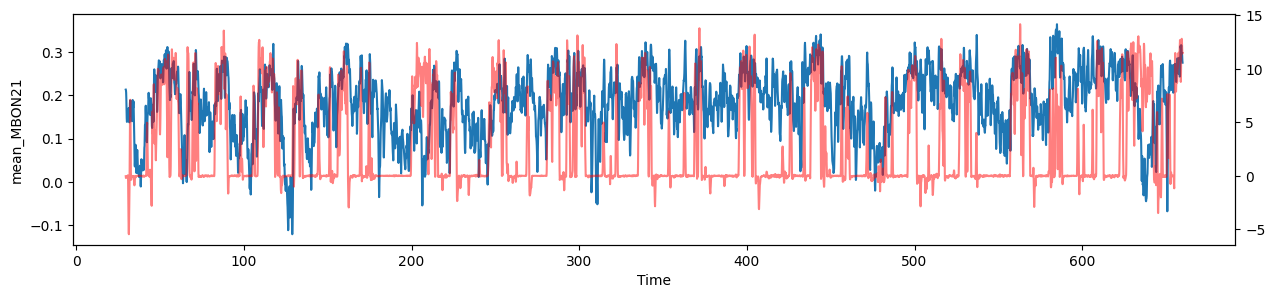

In [245]:
key = 'mean_MBON21'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 250
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.fwV[idx1:idx2], color='red',alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

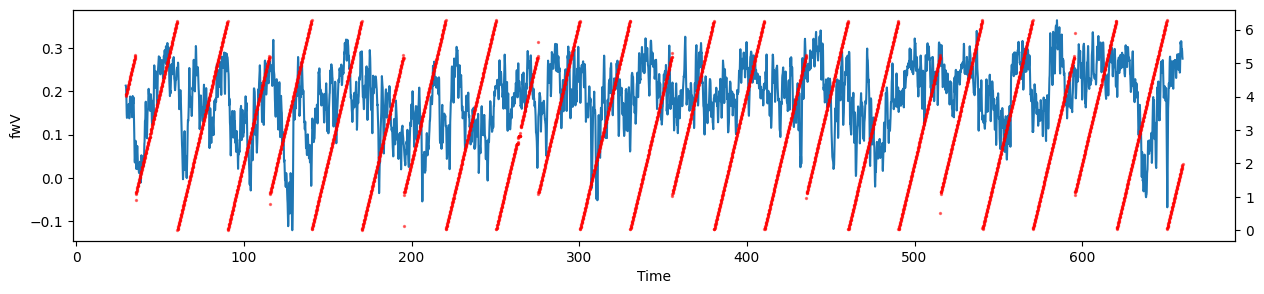

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2])
ax2 = ax.twinx()
ax2.scatter(merged_df.time[idx1:idx2], merged_df.heading[idx1:idx2], color='red',s = 2, alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('fwV')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

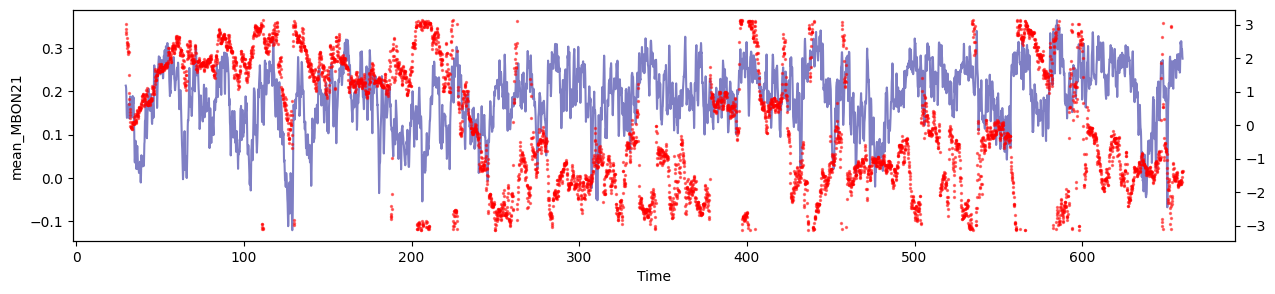

In [247]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color = 'darkblue',alpha =0.5)
ax2 = ax.twinx()
ax2.scatter(neural_df.time[idx1:idx2], neural_df.phase[idx1:idx2], color='red',s = 2, alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)


plt.show()

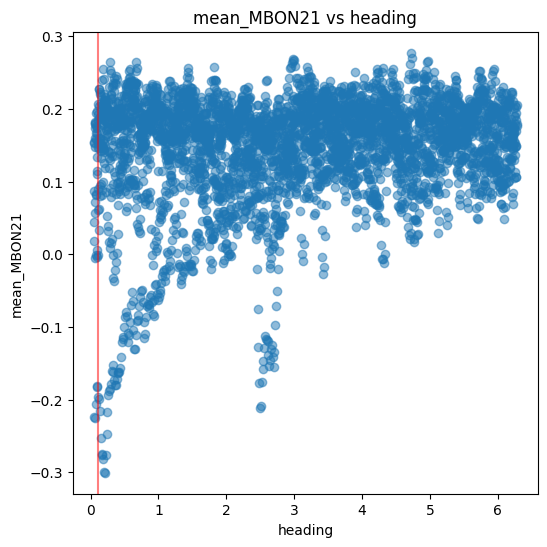

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
merged_df_copy = merged_df[~((merged_df['heading']<0+0.05) & (merged_df['heading']>0-0.05))]
imaging_behavior_functions_plotting.plot_scatter(merged_df_copy, 'heading', key, ax=ax, return_fig=False)
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['heading'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)

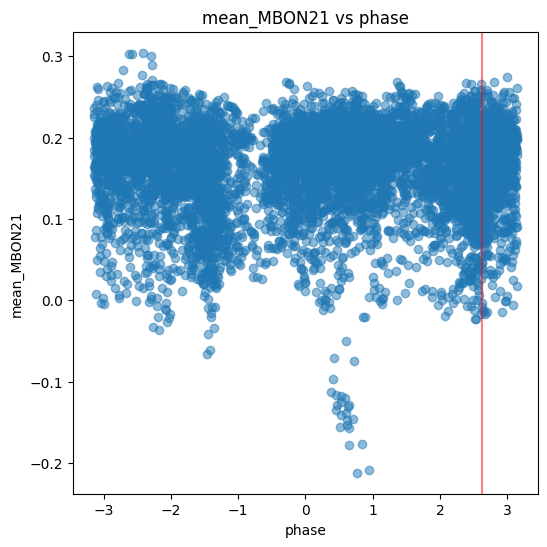

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
imaging_behavior_functions_plotting.plot_scatter(merged_df.iloc[idx1:idx2], 'phase', 'mean_MBON21', ax=ax, return_fig=False)
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['phase'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)


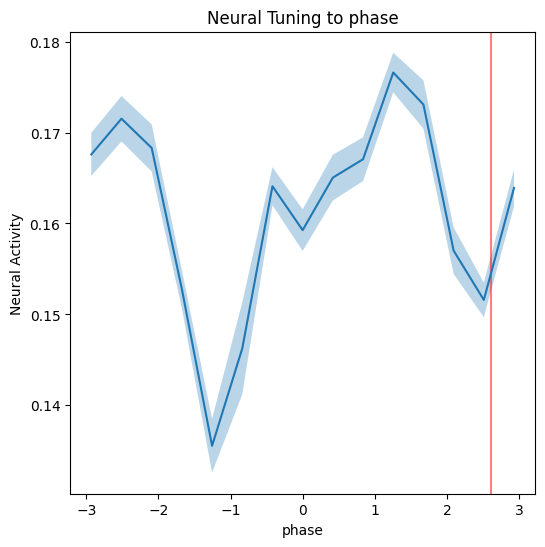

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#imaging_behavior_functions_plotting.plot_scatter(merged_df, 'phase', 'mean_MBON21', ax=ax, return_fig=False)
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['phase'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)
imaging_behavior_functions_plotting.tuning_curve_1d(merged_df.iloc[idx1:idx2], 'phase', key, num_bins=15, ax=ax, return_fig=False)

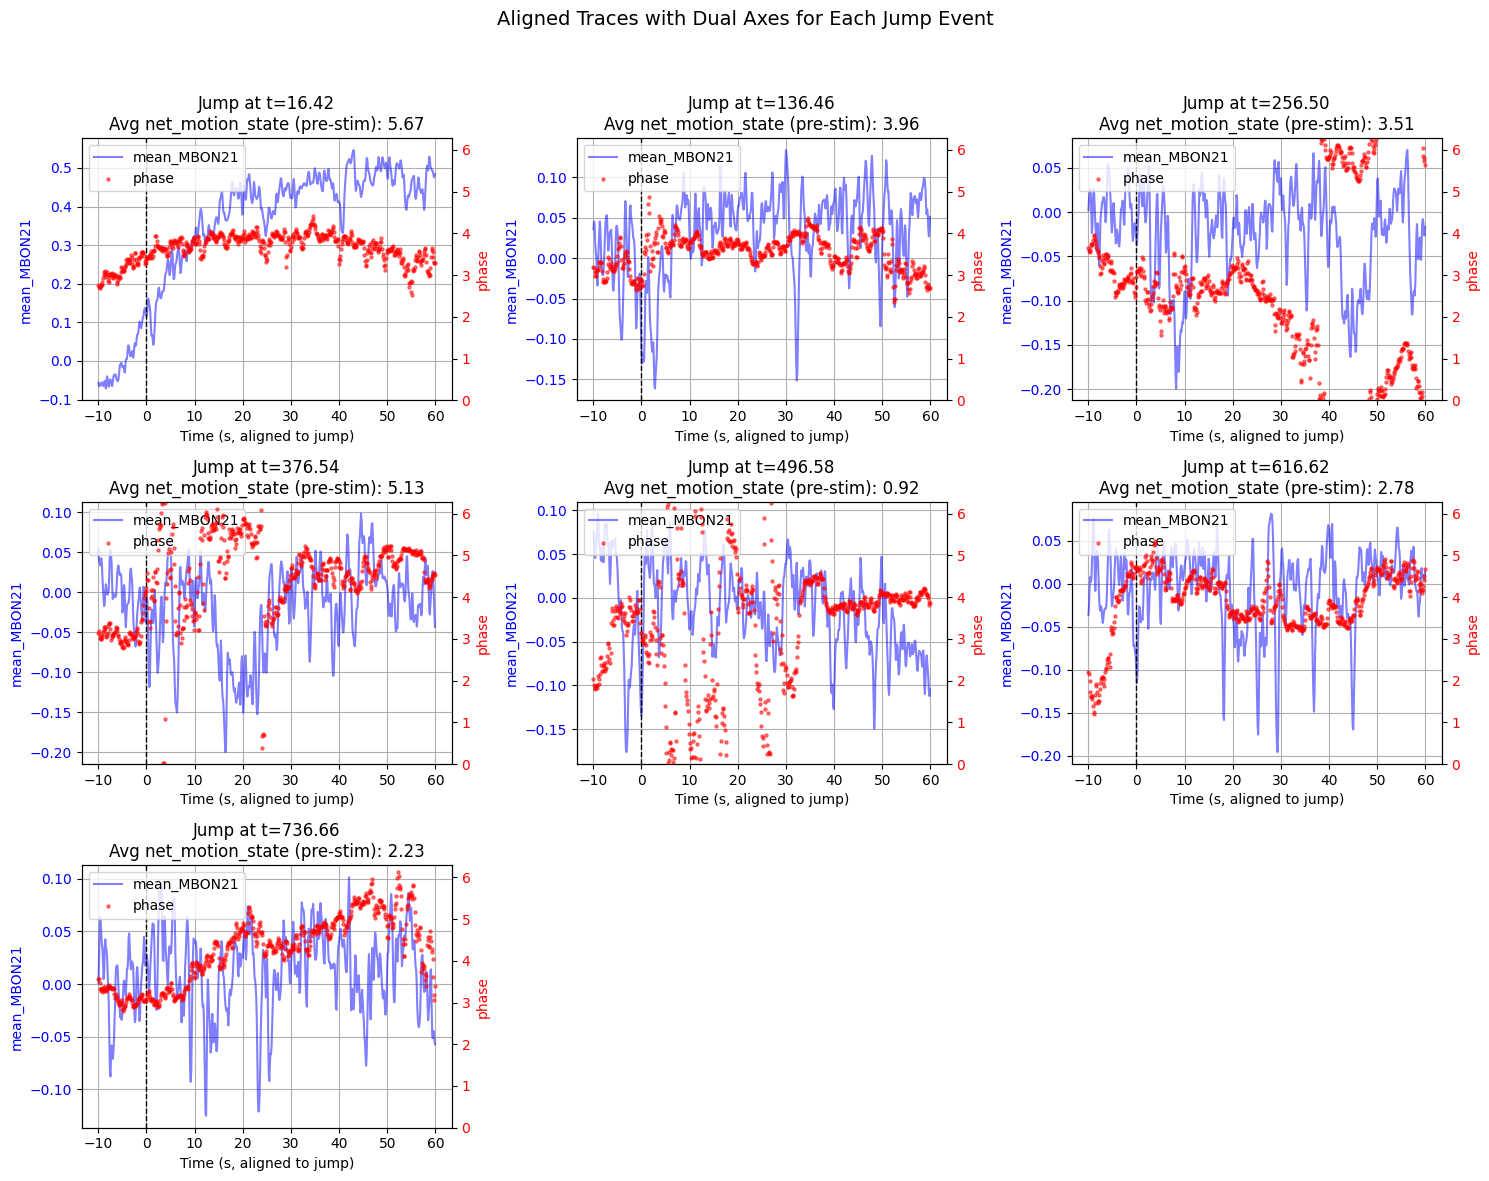

In [241]:
plot_aligned_traces_twinx(
    merged_df, 'bar_sweep', ['mean_MBON21','phase'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

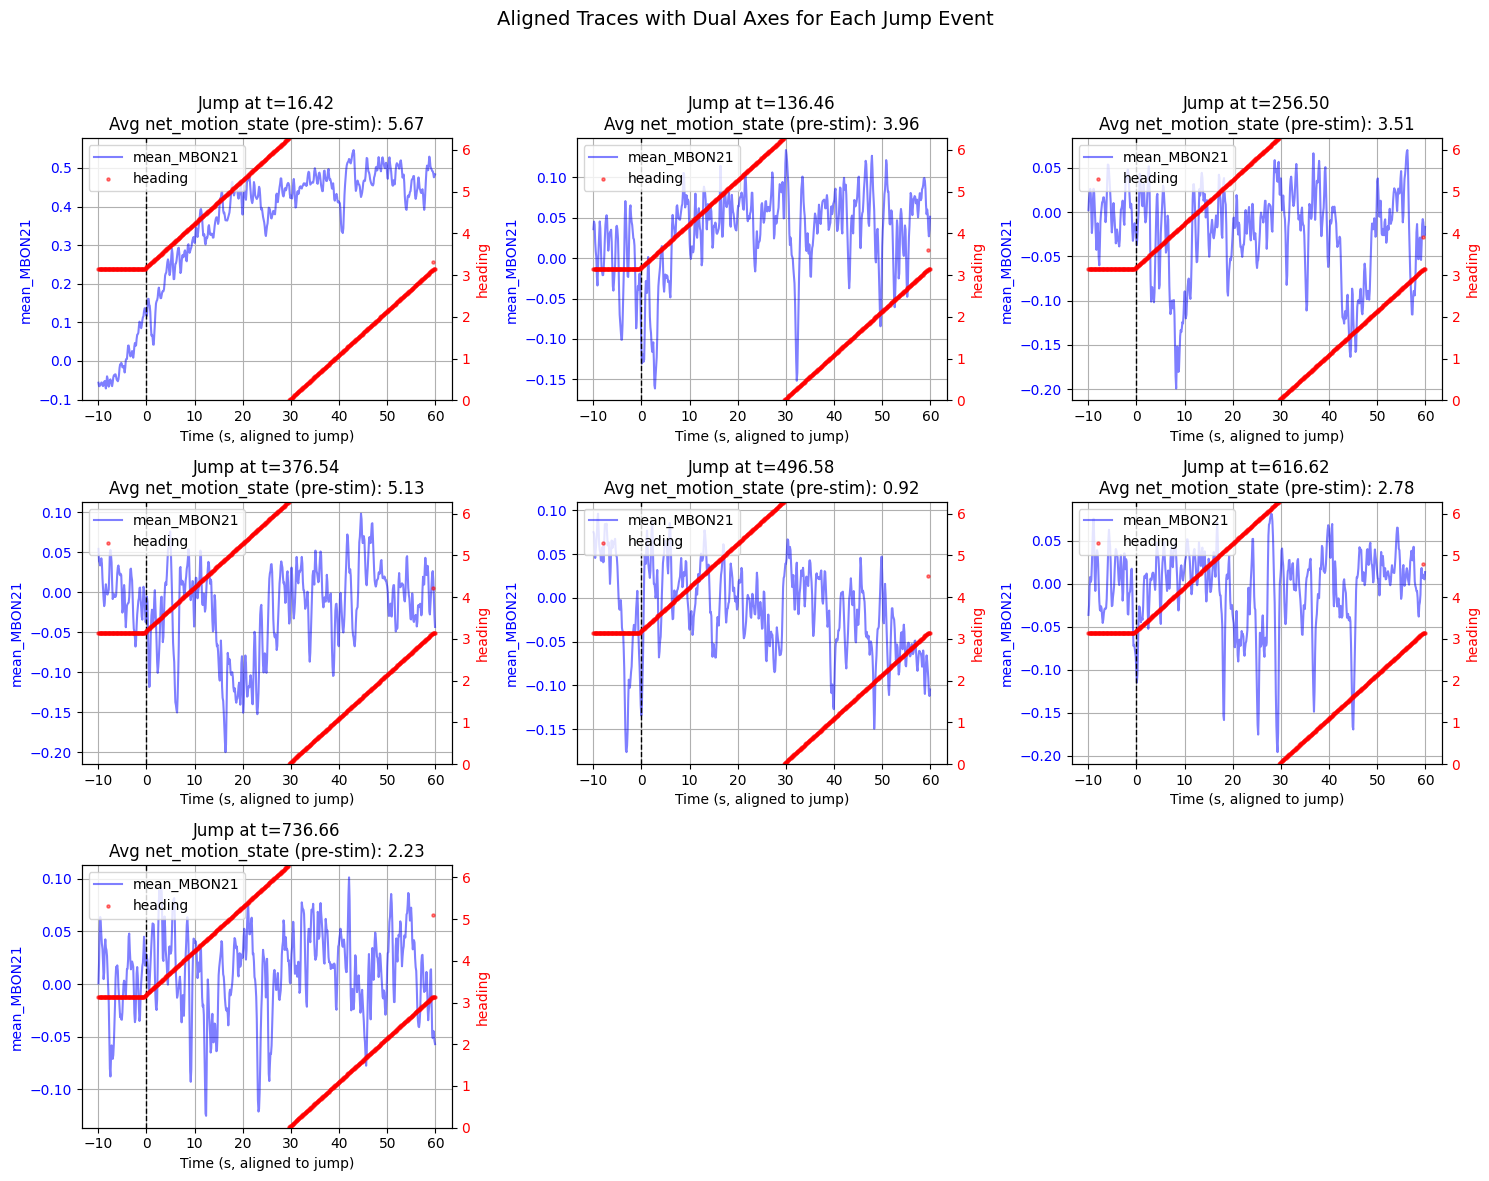

In [242]:
plot_aligned_traces_twinx(
    merged_df, 'bar_sweep', ['mean_MBON21','heading'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

### Load new and examine bar jump

In [109]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/"
folder_name = "20250219-4_MBON21hDeltaB_jump_fly2"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 2
bar_jump = True
bar_sweep = False
is_mat73, roi_df, dff_raw = imaging_behavior_functions_cleaned.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq_2(roi_df,trial_num)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df,param_df = imaging_behavior_functions_cleaned.fit_sinusoid(neural_df, roi_mtx)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions_cleaned.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions_cleaned.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions_cleaned.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions_cleaned.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=75)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior_new(behav_df)
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(neural_df, behav_df)
if bar_sweep:
    merged_df=imaging_behavior_functions_cleaned.detect_bar_sweep(merged_df, theta=0, t2=60, noise_threshold=0.05, duration_tol=0.5)
# bar jump use nearest method, bar sweep use interp method

Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Loaded using mat73.


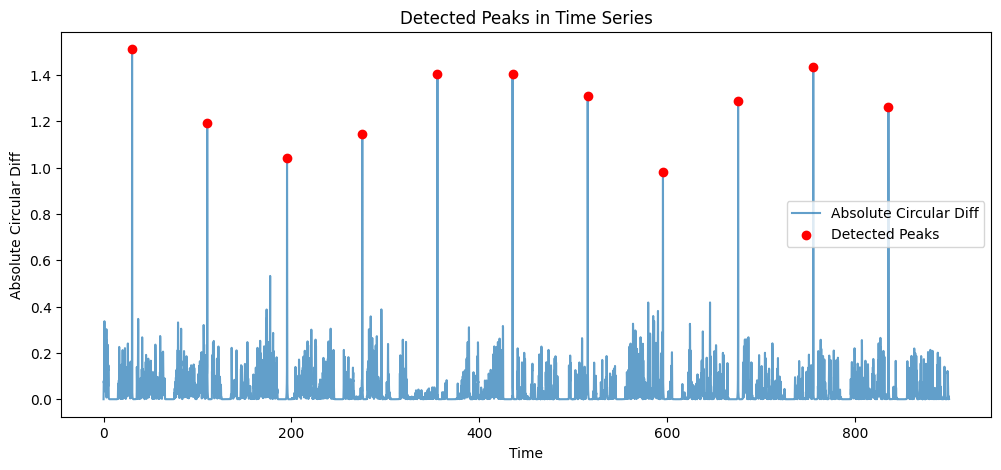

In [221]:
# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(behav_df["time"], behav_df["absolute_circular_diff"], label="Absolute Circular Diff", alpha=0.7)
plt.scatter(behav_df[behav_df["jump_detected"] == 1]["time"], 
            behav_df[behav_df["jump_detected"] == 1]["absolute_circular_diff"], 
            color='red', label="Detected Peaks", zorder=3)
plt.xlabel("Time")
plt.ylabel("Absolute Circular Diff")
plt.legend()
plt.title("Detected Peaks in Time Series")
plt.show()




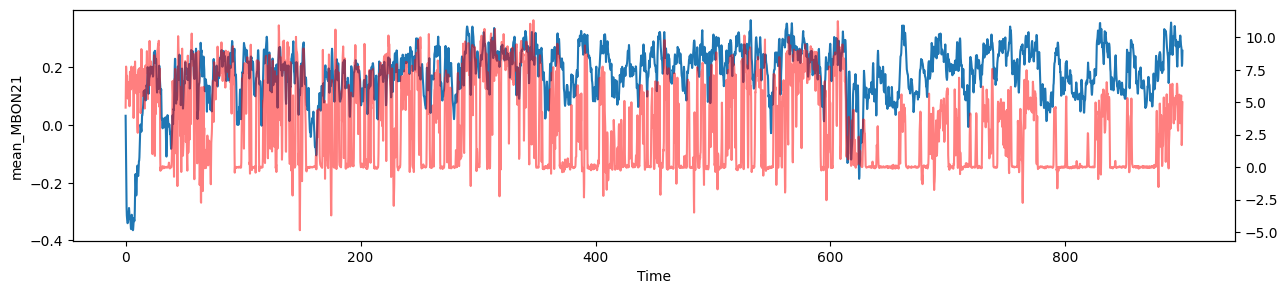

In [110]:
key = 'mean_MBON21'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.fwV[idx1:idx2], color='red',alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

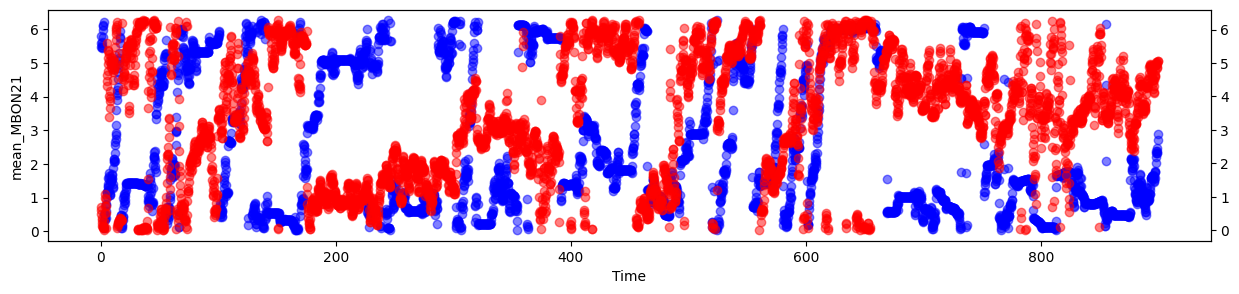

In [111]:
key = 'mean_MBON21'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.scatter(merged_df.time[idx1:idx2], merged_df.heading[idx1:idx2], color='blue',alpha=0.5)
ax2 = ax.twinx()
ax2.scatter(merged_df.time[idx1:idx2], merged_df.phase[idx1:idx2], color='red',alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

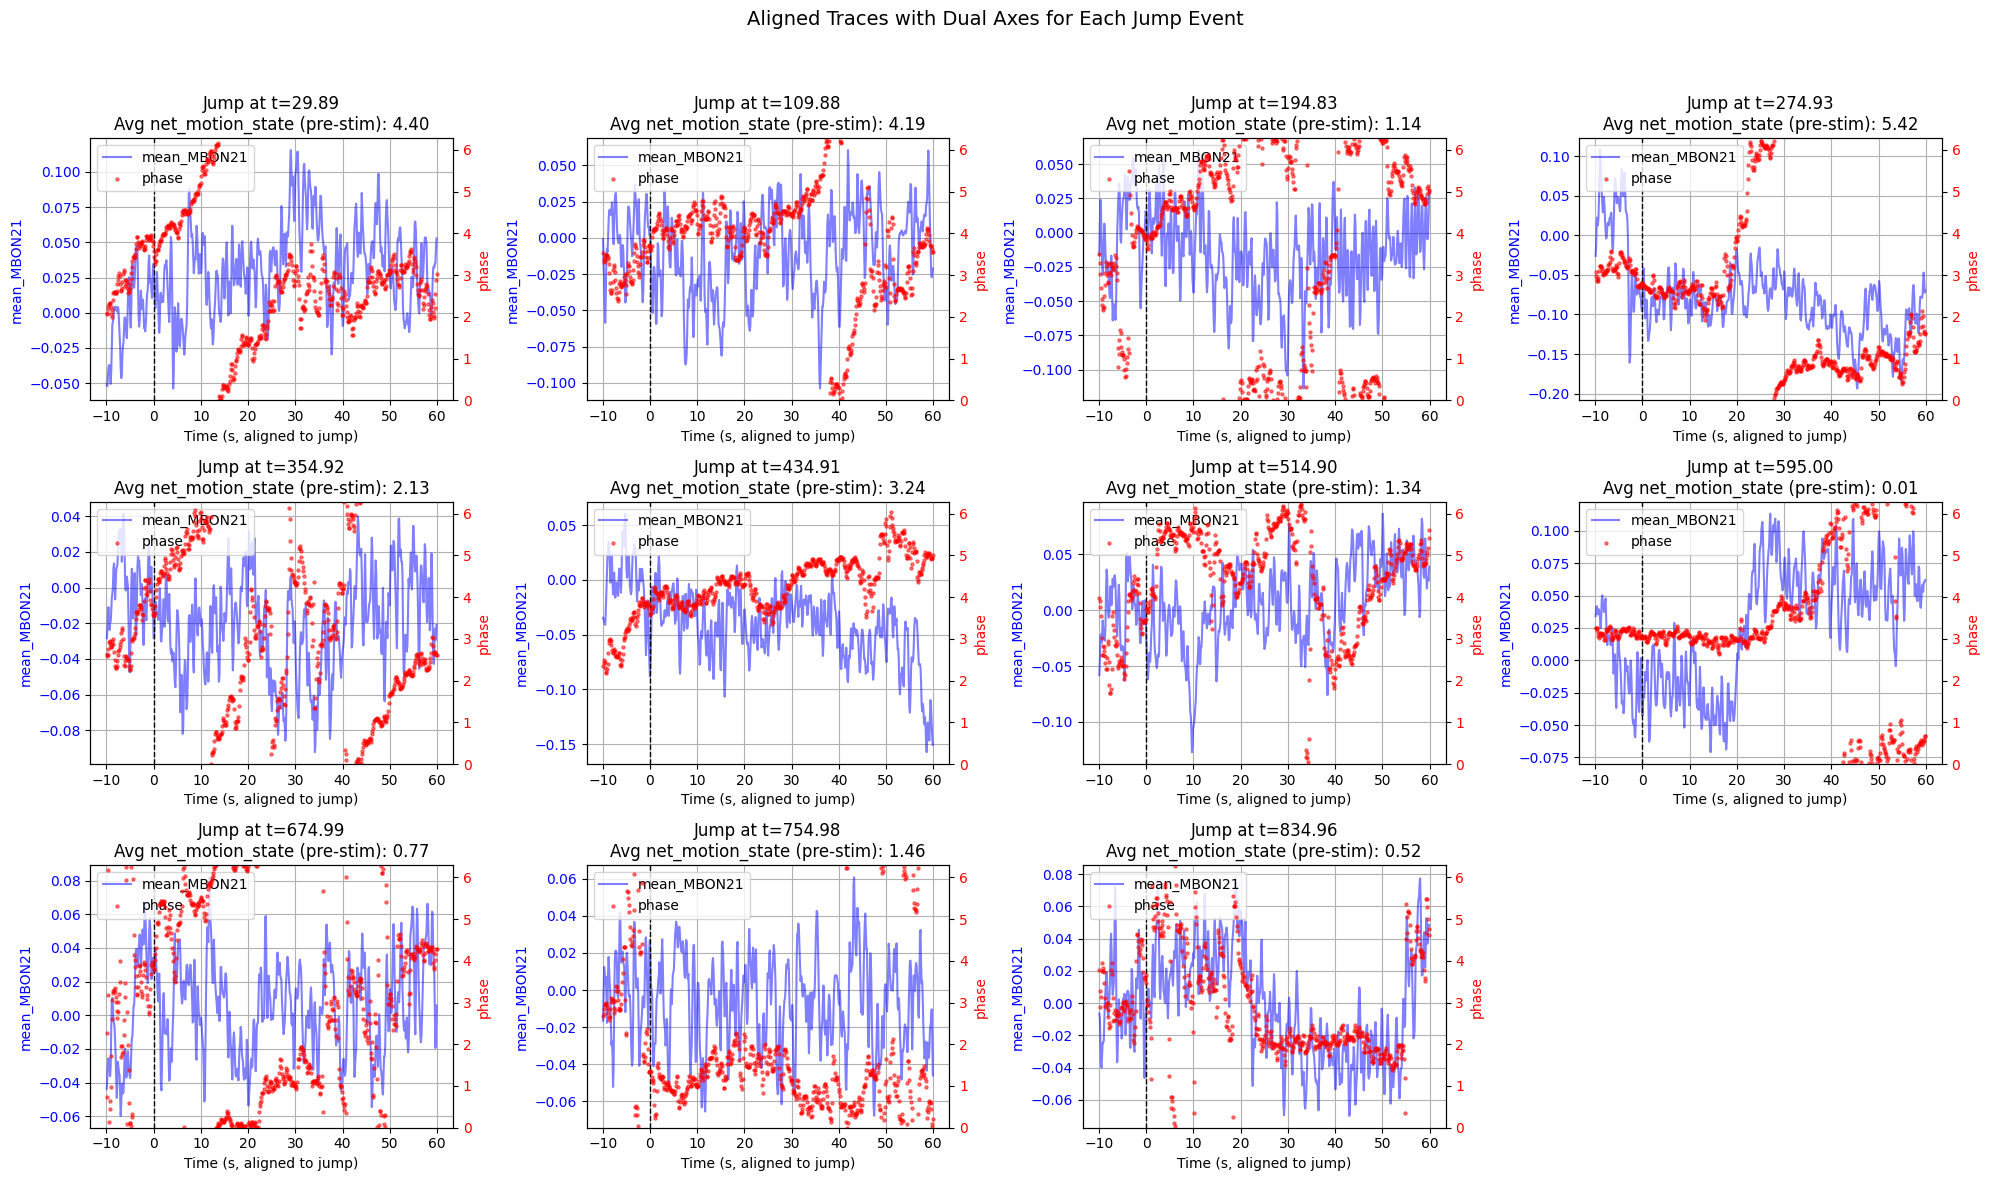

In [216]:
plot_aligned_traces_twinx(
    merged_df, 'jump_detected', ['mean_MBON21','phase'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

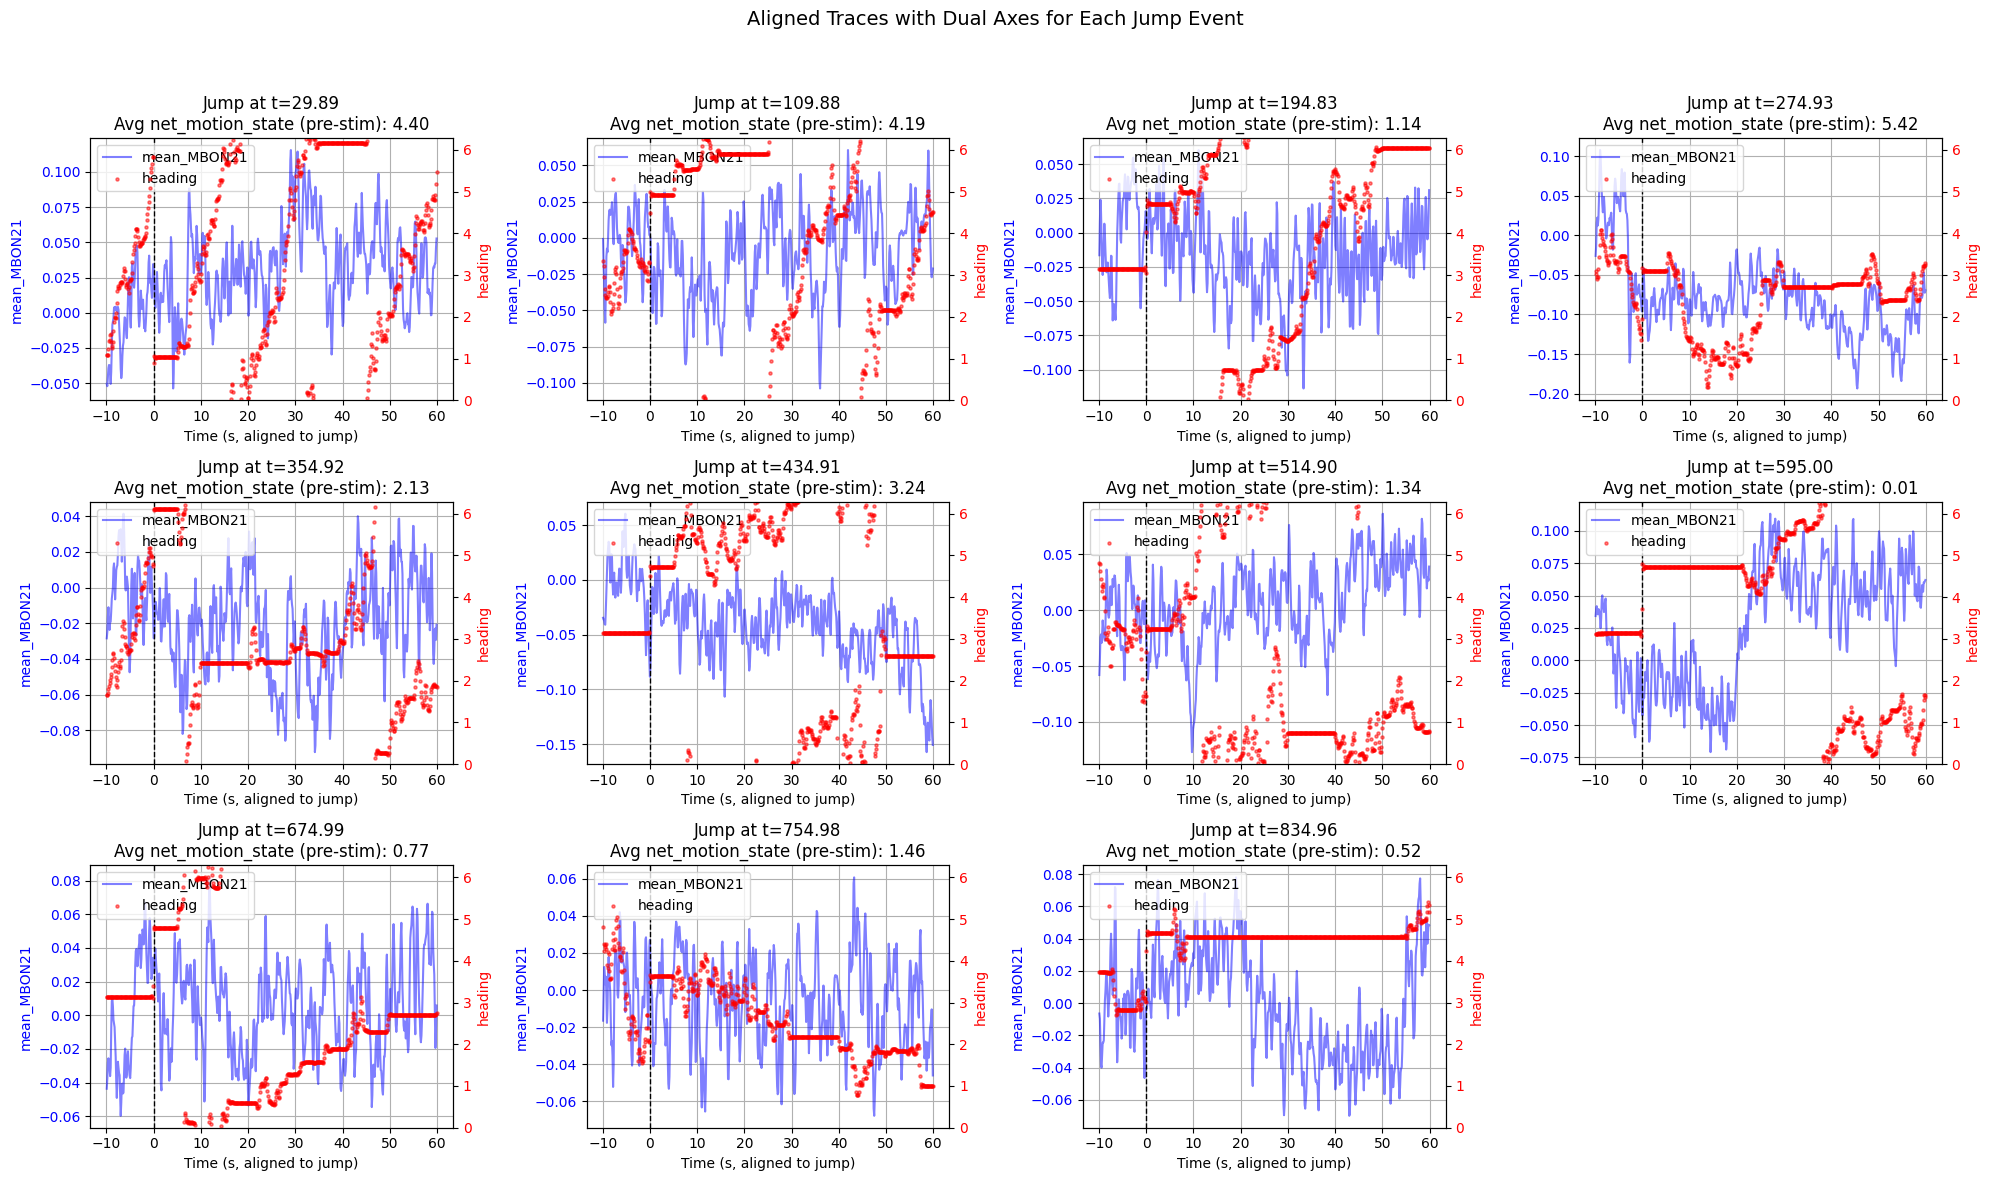

In [217]:
plot_aligned_traces_twinx(
    merged_df, 'jump_detected', ['mean_MBON21','heading'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

In [ ]:
plot_heatmap_aligned_traces(
   merged_df, 'jump_detected', ['mean_MBON09','fwV','phase','heading'], 'time',align_to="on", window=(-10, 60), is_circular=[False,False,True,True], do_baselincorr=True
)

In [ ]:
plot_neural_activity(merged_df, 15, 60, plot_columns=["MBON09R","MBON09L"], sigma=None, plot_kw='on_avg_fwv', is_onset=True, bounds=None,percentile_range=[0, 100])



### Load new and examine dark


In [223]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/"
folder_name = "20250302-4_MBON09hDeltaB_nobar"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 2
bar_jump = False
bar_sweep = False
is_mat73, roi_df, dff_raw = imaging_behavior_functions_cleaned.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq_2(roi_df,trial_num)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions_cleaned.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions_cleaned.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions_cleaned.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions_cleaned.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=60)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior_new(behav_df)
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(neural_df, behav_df)
if bar_sweep:
    merged_df=imaging_behavior_functions_cleaned.detect_bar_sweep(merged_df, theta=0, t2=60, noise_threshold=0.05, duration_tol=0.5)
# bar jump use nearest method, bar sweep use interp method

Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
Loaded using mat73.


<Axes: >

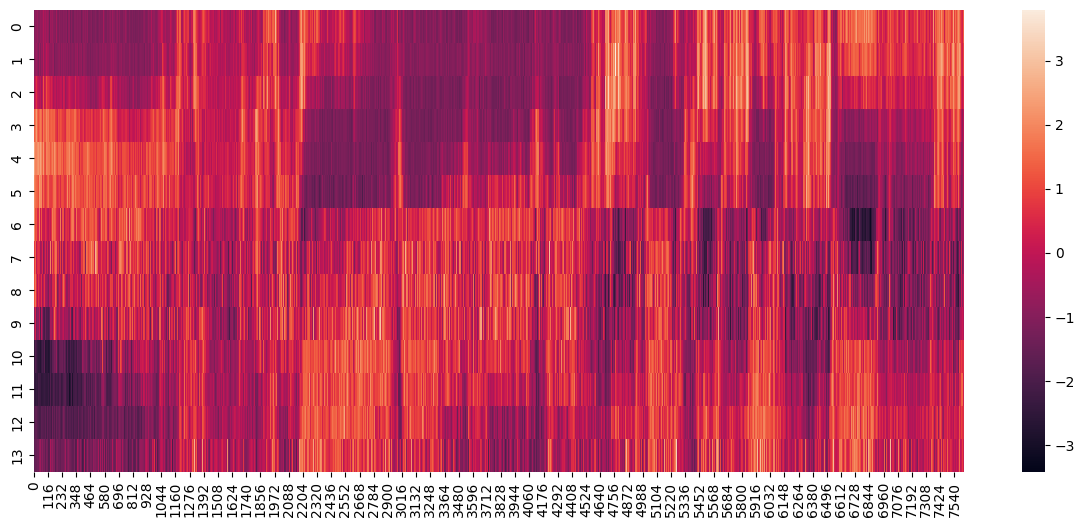

In [229]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.heatmap(roi_mtx.T, ax=ax)


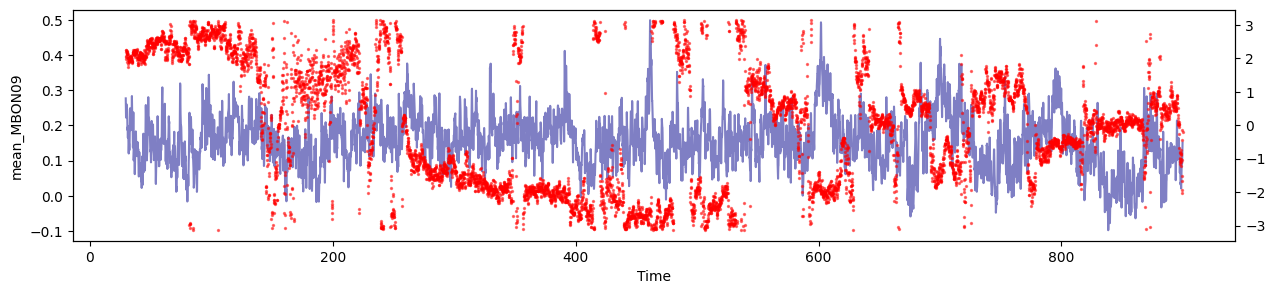

In [224]:
key = 'mean_MBON09'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color = 'darkblue',alpha =0.5)
ax2 = ax.twinx()
ax2.scatter(neural_df.time[idx1:idx2], neural_df.phase[idx1:idx2], color='red',s = 2, alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)


plt.show()

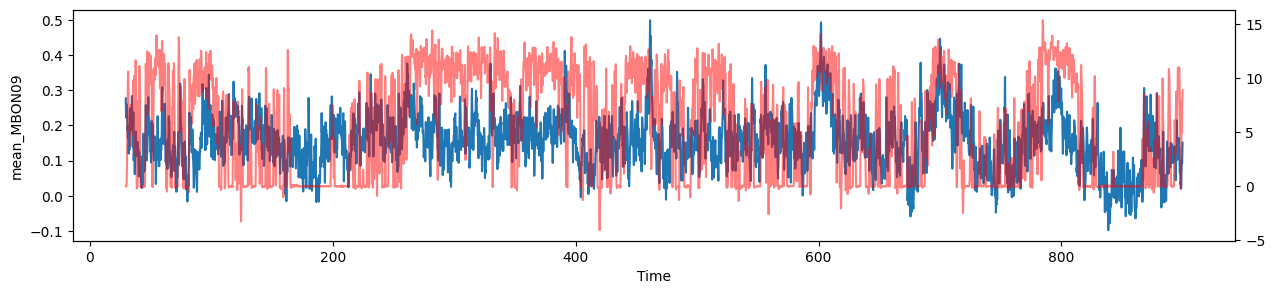

In [200]:

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 250
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.fwV[idx1:idx2], color='red',alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

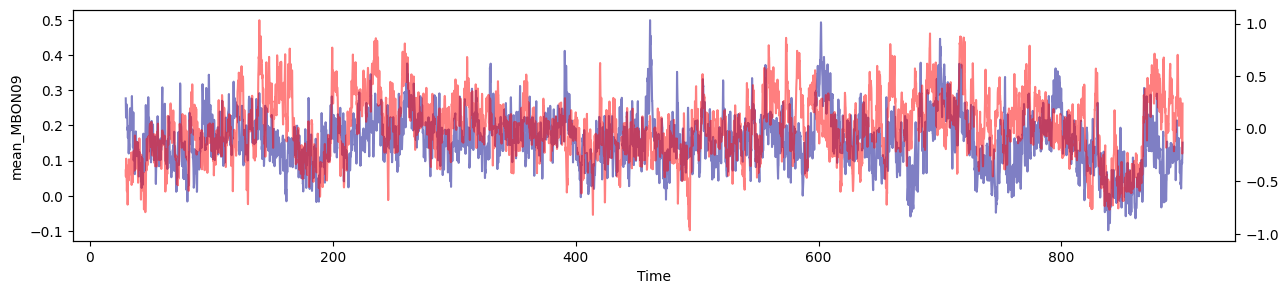

In [199]:
key = 'mean_MBON09'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color = 'darkblue',alpha =0.5)
ax2 = ax.twinx()
ax2.plot(neural_df.time[idx1:idx2], neural_df.baseline[idx1:idx2], color='red', alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)


plt.show()